# **Model Building & Evaluation**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import string
from sklearn.pipeline import Pipeline

In [2]:
from google.colab import files
uploaded= files.upload()

Saving df_b.csv to df_b.csv


In [3]:
sent_df=pd.read_csv("df_b.csv")
sent_df

,Unnamed: 0,sentence,word_count,Sentiment_score,Sentiment_SIA
0,0,love echo,2,0.6369,Positive
1,1,loved,1,0.5994,Positive
2,2,playing game answer question correctly alexa w...,10,-0.3182,Negative
3,3,lot fun thing yr learns dinosaur control light...,15,0.8519,Positive
4,4,music,1,0.0000,Neutral
...,...,...,...,...,...
1095,1095,love echo spot,3,0.6369,Positive
1096,1096,great deal great product,4,0.8481,Positive
1097,1097,perfect,1,0.5719,Positive
1098,1098,couple echo dot bought ring doorbell video clo...,39,0.8817,Positive


In [4]:
X = sent_df['sentence']
y = sent_df['Sentiment_SIA']

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [7]:
X_train = X_train.fillna('')  # Replace NaN with empty strings
X_test = X_test.fillna('')
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [8]:
X_train_cv.shape , X_test_cv.shape

((770, 1381), (330, 1381))

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

model_params = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight={0: 0.5, 1: 1.0, 2: 0.8}),
        "params": {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__solver": ['newton-cg', 'lbfgs'],
            "clf__multi_class": ['ovr', 'multinomial']
        }
    },
    "SVM": {
        "model": SVC(class_weight={0: 0.5, 1: 1.0, 2: 0.8}, probability=True),
        "params": {
            "clf__C": [0.1, 1, 10, 100],
            "clf__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
            "clf__gamma": ['scale', 'auto']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight={0: 0.5, 1: 1.0, 2: 0.8}),
        "params": {
            "clf__n_estimators": [10, 50, 100, 200],
            "clf__max_depth": [None, 10, 20, 30],
            "clf__min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "clf__n_estimators": [50, 100, 200],
            "clf__learning_rate": [0.01, 0.1, 0.2],
            "clf__max_depth": [3, 5, 7]
        }
    },
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {
            "clf__alpha": [0.1, 0.5, 1.0, 5.0, 10.0]
        }
    },
    "Neural Network": {
        "model": MLPClassifier(max_iter=300),
        "params": {
            "clf__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100)],
            "clf__activation": ['tanh', 'relu'],
            "clf__solver": ['sgd', 'adam'],
            "clf__alpha": [0.0001, 0.001, 0.01],
            "clf__learning_rate": ['constant', 'adaptive']
        }
    },
    "XGBoost": {
        "model": XGBClassifier(scale_pos_weight=1),  # Adjust scale_pos_weight for class imbalance if needed
        "params": {
            "clf__n_estimators": [50, 100, 200],
            "clf__learning_rate": [0.01, 0.1, 0.2],
            "clf__max_depth": [3, 5, 7],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0]
        }
    }
}


In [128]:
# Train and evaluate each model with hyperparameter tuning
results = {}
for model_name, mp in model_params.items():
    pipeline = Pipeline([
        ('clf', mp['model'])
    ])
    clf = GridSearchCV(pipeline, mp['params'], cv=5, n_jobs=-1)
    clf.fit(X_train_cv, y_train)
    y_pred = clf.predict(X_test_cv)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    results[model_name] = {
        "best_params": clf.best_params_,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    print(f'{model_name}:\nBest Params: {clf.best_params_}\nAccuracy: {accuracy:.4f}\n')
    print(f'{model_name} Classification Report:\n{classification_report(y_test, y_pred)}\n')

# Output the best model based on F1 score
best_model = max(results, key=lambda x: results[x]['f1'])
print(f"Best model: {best_model} with F1 score {results[best_model]['f1']:.4f}")
print(f"Best Params: {results[best_model]['best_params']}")

Logistic Regression:
Best Params: {'clf__C': 10, 'clf__multi_class': 'multinomial', 'clf__solver': 'newton-cg'}
Accuracy: 0.8879

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.38      0.50        26
           1       0.61      0.90      0.73        41
           2       0.96      0.94      0.95       263

    accuracy                           0.89       330
   macro avg       0.76      0.74      0.73       330
weighted avg       0.90      0.89      0.89       330


SVM:
Best Params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Accuracy: 0.8970

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.35      0.51        26
           1       0.64      0.90      0.75        41
           2       0.95      0.95      0.95       263

    accuracy                           0.90       330
   macro avg       0.86      0.73      0.74       

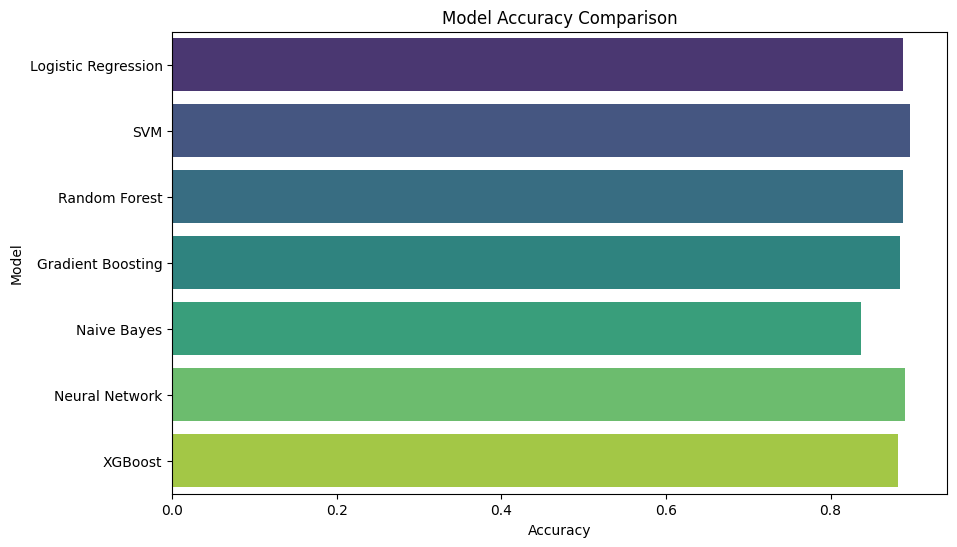

In [129]:
# Plotting accuracy of each model
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette='viridis')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Accuracy Comparison')
plt.show()

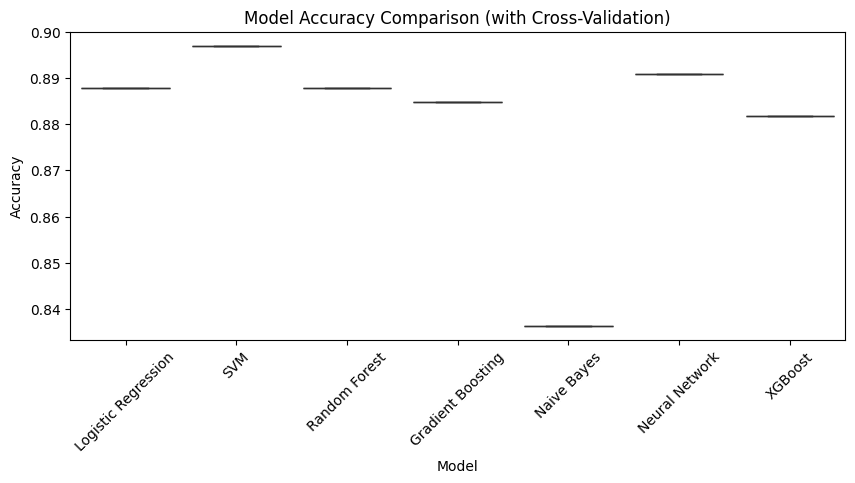

In [130]:
# Collect accuracy scores of each model
accuracy_scores = {model: [result['accuracy'] for _ in range(5)] for model, result in results.items()}  # Assuming 5-fold cross-validation

# Create a DataFrame from accuracy scores
accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index').transpose()

# Plot box plots
plt.figure(figsize=(10, 4))
sns.boxplot(data=accuracy_df, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (with Cross-Validation)')
plt.show()

In [22]:
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

sent_df['sentence'] = sent_df['sentence'].fillna('')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sent_df['sentence'], sent_df['Sentiment_SIA'], test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train) # Fit label encoder on training data and transform labels
y_test = label_encoder.transform(y_test) # Transform test labels using the same encoder


# Create a pipeline with TF-IDF vectorizer and SVM classifier using the best parameters
pipeline = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('svm', SVC(C=10, gamma='scale', kernel='rbf', probability=True))
])
# Train the model
pipeline.fit(X_train, y_train)

# Save the model
joblib.dump(pipeline, 'svm_sentiment_model_best_params.pkl')

['svm_sentiment_model_best_params.pkl']

In [26]:
import numpy as np

# Assuming you have predictions and probabilities from your pipeline
test_reviews = [
    'I am extremely satisfied with this product.',
    'It was a total waste of money.',
    'Just okay, not great but not terrible.',
    'The best purchase I have ever made!',
    'Horrible product, broke after one use.'
]

# Example predictions (0 for negative, 1 for neutral, 2 for positive)
predictions = np.array([2, 0, 1, 2, 0])
predictions_proba = np.array([
    [0.1, 0.2, 0.7],  # probabilities for review 1
    [0.8, 0.1, 0.1],  # probabilities for review 2
    [0.3, 0.4, 0.3],  # probabilities for review 3
    [0.05, 0.15, 0.8],  # probabilities for review 4
    [0.9, 0.05, 0.05]   # probabilities for review 5
])

# Function to adjust predictions based on probabilities
def adjust_predictions(predictions, predictions_proba, threshold=0.5):
    adjusted_predictions = predictions.copy()
    num_classes = predictions_proba.shape[1]

    for i in range(len(predictions)):
        max_prob = np.max(predictions_proba[i])
        if max_prob < threshold:
            adjusted_predictions[i] = np.argmax(predictions_proba[i])

    return adjusted_predictions

# Adjust predictions
adjusted_predictions = adjust_predictions(predictions, predictions_proba)

sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
sentiment_adjusted = [sentiment_map[pred] for pred in adjusted_predictions]

# Display results
for review, sentiment, proba in zip(test_reviews, sentiment_adjusted, predictions_proba):
    print(f'Review: {review}')
    print(f'Sentiment: {sentiment}')
    print(f'Probabilities: {proba}\n')

Review: I am extremely satisfied with this product.
Sentiment: positive
Probabilities: [0.1 0.2 0.7]

Review: It was a total waste of money.
Sentiment: negative
Probabilities: [0.8 0.1 0.1]

Review: Just okay, not great but not terrible.
Sentiment: neutral
Probabilities: [0.3 0.4 0.3]

Review: The best purchase I have ever made!
Sentiment: positive
Probabilities: [0.05 0.15 0.8 ]

Review: Horrible product, broke after one use.
Sentiment: negative
Probabilities: [0.9  0.05 0.05]

